# Linkin Nodes

In [28]:
import sys
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

%load_ext autoreload
%autoreload 2
from data.ArticlesParser import process_articles_directory
from data.Graph import *
from data.Preprocessing import *
from utils.Visualization import *
from sentence_transformers import SentenceTransformer, util


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Preprocessing

In [2]:
data_path = os.path.abspath(os.path.join(os.getcwd(), 'data'))
articles_path = os.path.join(data_path, 'plaintext_articles')

# change_name_files_plaintext_articles(data_path)

parsed_articles = process_articles_directory(articles_path)
df = pd.DataFrame(parsed_articles, columns=['Article_Title', 'Related_Subjects', 'Description'])
print(f"There are : {len(df)} articles")
df.head()

There are : 4598 articles


,Article_Title,Related_Subjects,Description
0,Second_Crusade,"[Military History and War, Religious disputes]",The Second Crusade was the second major crusad...
1,Navassa_Island,[North American Geography],"Navassa Island (French: La Navase, Haitian Kre..."
2,Evan_Rachel_Wood,"[Actors, models and celebrities]","Evan Rachel Wood (born September 7, 1987) is a..."
3,Tropical_Storm_Henri_(2003),[Storms],Tropical Storm Henri was a weak tropical storm...
4,Final_Fantasy_Adventure,[Computer & Video games],Final Fantasy Adventure (originally released i...


In [3]:
df_links = preprocessing_links(data_path)
df_links.head()

,Articles,Links
0,10th_century,"[11th_century, 9th_century, Algeria, Beer, Bla..."
1,11th_century,"[10th_century, 12th_century, 13th_century, 14t..."
2,12th_century,"[10th_century, 11th_century, 13th_century, 14t..."
3,13th_century,"[12th_century, 14th_century, Angola, Arabic_la..."
4,14th_century,"[13th_century, 15th_century, Abacus, Aztec, Bl..."


## 2. Model choice and embeddings

The SentenceTransformer("all-MiniLM-L6-v2") model is a popular choice for natural language processing tasks that involve embedding sentences into a dense vector space. It strikes an excellent balance between performance and efficiency, making it highly practical for a wide range of applications.

This model is specifically fine-tuned for generating meaningful sentence embeddings, allowing it to capture the semantic essence of sentences effectively. Its compact size ensures that it is not only fast but also resource-efficient, making it particularly well-suited for real-time or large-scale applications where computational efficiency is crucial

In [4]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [5]:
# This needs to calculate the embeddings for each article and description, takes time.
embedded_articles = articles_to_embeddings(parsed_articles, model)

In [6]:
for title in embedded_articles:
    score = util.dot_score(*embedded_articles[title])
    if score < 0.2:
        print(f"{title} score: {float(score):.4f}")

Lottie_Dod score: 0.1621
Cheers score: 0.1901
Amur score: 0.1967


In [7]:
# Both are science fiction writers. Using only their names, the cosine similarity
# is low. But with more context, their cosine similarity is high. They are indeed
# bi-directionally linked as they had influence in each other's lives.
print("John Campbell and Isaac Asimov comparison")
john_embedding, john_desc_embedding = embedded_articles["John_W._Campbell"]
isaac_embedding, isaac_desc_embedding = embedded_articles["Isaac_Asimov"]
print(f"Cosine similarity between article names: {float(util.dot_score(john_embedding, isaac_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(john_desc_embedding, isaac_desc_embedding)):.4f}")

# It can also help to disambiguate: a limerick is a form of poetry, so these two
# should be linked if we only take into account the article name. But the Limerick
# article actually talks about the city in Ireland, not the form of poetry.
print("\nLimerick and Poetry comparison")
limerick_embedding, limerick_desc_embedding = embedded_articles["Limerick"]
poetry_embedding, poetry_desc_embedding = embedded_articles["Poetry"]
print(f"Cosine similarity between article names: {float(util.dot_score(limerick_embedding, poetry_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(limerick_desc_embedding, poetry_desc_embedding)):.4f}")

# In the case where the articles should be linked but the description isn't similar
# like winter and summer which are opposing, the description cosine similarity is
# lower, but closer to the article name similarity than in the case of disambiguation.
print("\nWinter and Summer comparison")
winter_embedding, winter_desc_embedding = embedded_articles["Winter"]
summer_embedding, summer_desc_embedding = embedded_articles["Summer"]
print(f"Cosine similarity between article names: {float(util.dot_score(winter_embedding, summer_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(winter_desc_embedding, summer_desc_embedding)):.4f}")

John Campbell and Isaac Asimov comparison
Cosine similarity between article names: 0.2334
Cosine similarity between descriptions: 0.5171

Limerick and Poetry comparison
Cosine similarity between article names: 0.5433
Cosine similarity between descriptions: 0.1685

Winter and Summer comparison
Cosine similarity between article names: 0.6008
Cosine similarity between descriptions: 0.4943


Discussion:
Intuitively, articles should be linked if the cosine similarity between descriptions is higher than a certain threshold, while being close to the article names cosine similarity. But it is easier to let a neural network determine the weights while passing on both the article names and descriptions embeddings as variables for each node.

## 3. Graph

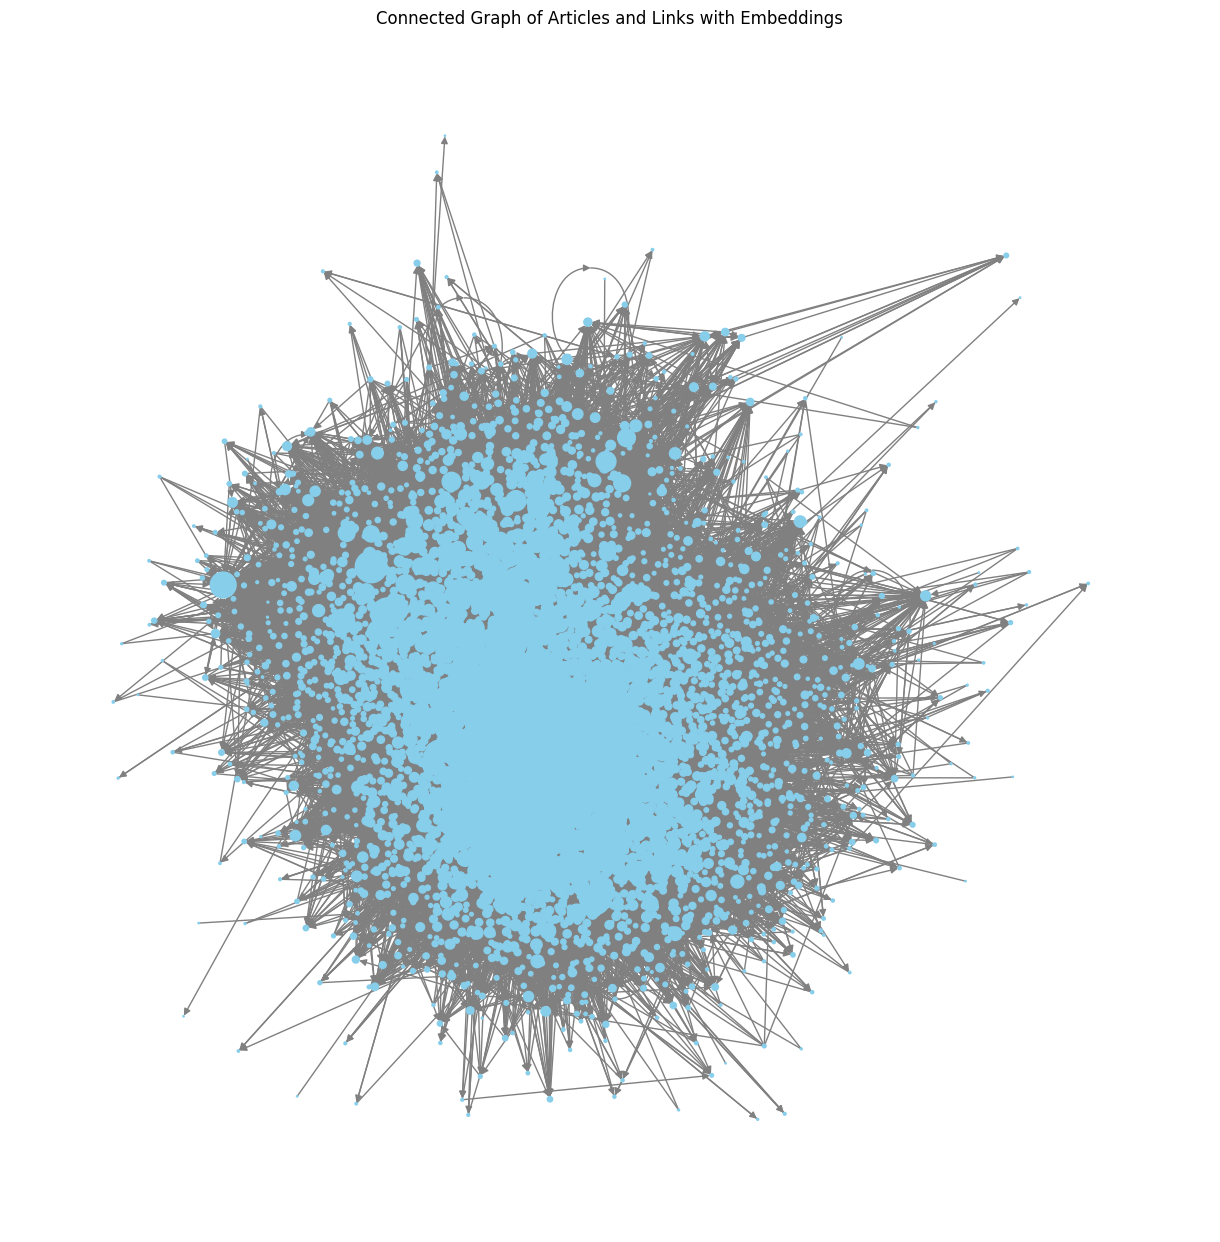

In [30]:
# Creation of the graph, takes time.
G=create_graph(embedded_articles, df_links)
visualize_graph(G)

### Graph statistical analysis 

To gain a better understanding of the data, some basics but important characteristics of the graph are computed/displayed. This will help guide us in selecting the most appropriate approach for the next steps.

In [9]:
#Make sure to have a connected graph without isolated nodes

#Here we create subgraphs for each connected component
components = list(nx.connected_components(G.to_undirected()))
print(f"Number of connected components: {len(components)}")
subgraphs = [G.to_undirected().subgraph(component).copy() for component in components]

for i in range(len(subgraphs)):
    subgraph_1 = subgraphs[i]
    print(f"Number of nodes in subgraph {i}: {subgraph_1.number_of_nodes()}, {subgraph_1.nodes()}")
    print(f"Number of edges in subgraph {i}: {subgraph_1.number_of_edges()}")


Number of connected components: 10
Number of nodes in subgraph 0: 4589, ['Second_Crusade', 'Navassa_Island', 'Evan_Rachel_Wood', 'Tropical_Storm_Henri_(2003)', 'Final_Fantasy_Adventure', 'Tornado', 'John_W._Campbell', 'Whooping_Crane', 'Shigin', 'Hafnium', 'Hawaiian_Goose', 'Ankylosaurus', 'Andriyivskyy_Descent', 'Supermarine_Spitfire', 'Carl_Jung', 'Fine_art', 'Arithmetic', 'Taj_Mahal', 'Social_capital', 'Nepal', 'Book_of_Common_Prayer', 'African_Buffalo', 'Luminiferous_aether', 'Chicago', 'Giza_pyramid_complex', 'Lyme_disease', 'Humour', 'Imperative_programming', 'Brain', 'Coconut', 'Tern', 'Wars_of_the_Roses', 'Davis_Cup', 'Great_Tit', 'Wave–particle_duality', 'Jean_Charles_de_Menezes', 'Local_community', 'Music_of_Spain', 'Terik', 'Bernard_Hinault', "Hickman's_potentilla", 'Eris_(dwarf_planet)', 'Intelligence', 'Margaret_Sanger', 'Bretton_Woods_system', 'Glastonbury_Festival', 'Oxygen', 'Gerald_Ford', 'Antarctic_Treaty_System', 'John_Locke', 'Martin_Luther_King,_Jr.', "Six-party_ta

Except subgraphs[0], the rest correpond to isolated node, so we can get rid of them in the rest of the analysis

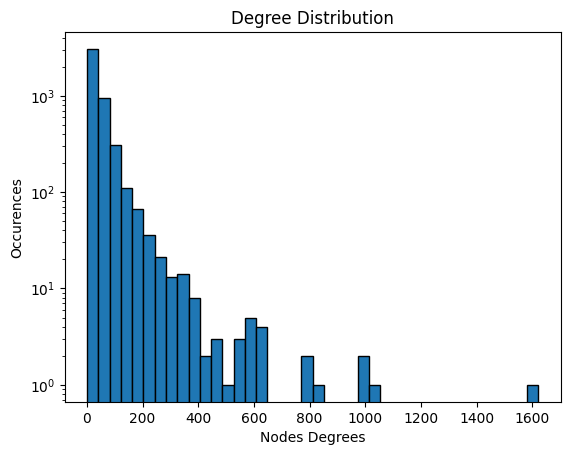

Number of nodes: 4589
Number of edges: 106644
Average degree: 46.48
Network density: 0.0101
Clustering coefficient: 0.2745
Average Shortest path: 2.5253


In [10]:
#subgraphs[0] is fully connected
analyze_graph_statistics(subgraphs[0])

### Results analysis

The graph is medium size and seems well connected, as the number of edges (>100000) is important compared to the number of nodes (~4500), and the average degree is pretty high (46.48).
The distribution of the nodes degrees is a right skewed distribution.
Thought the density is pretty low and indicates potential for discovering new links.
The clustering coefficient indicates that we are more likely to find local clusters.
Finally, it seems that most nodes can be reached from every other node in a small number of steps, as the avergae shortest path is ~2.53.

Thus, the features engineering focus should be on local structure features and short path, but the high connectivity suggests that global features could be important aswell.

## 4. Cosine similarity

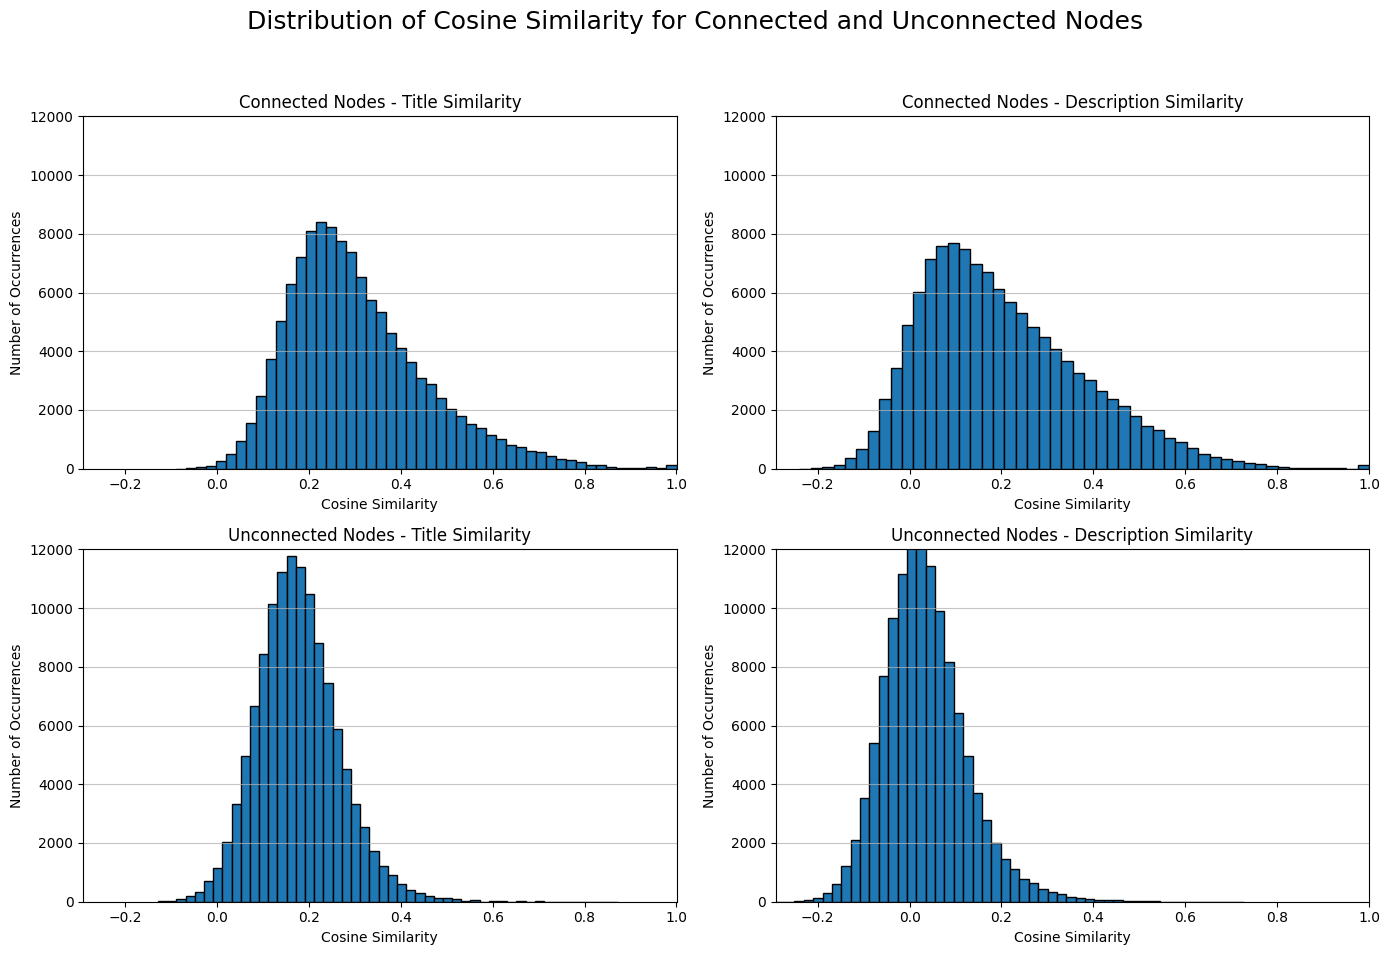

In [11]:
similarities = visualize_node_similarity_distributions(G)

Description:

Now to compare these distribution with the cosine similarities of article titles and descriptions between unconnected nodes, we will take a representative sample of the articles and calculate their cosine similarities.

In [12]:
for s in similarities['unconnected_pairs']:
    if s['title_similarity'] > 0.7 and s['description_similarity'] > 0.6:
        print(s['source'] + ' ' + s['target'])

Henry_VIII_of_England Henry_V_of_England
Henry_VIII_of_England Henry_III_of_England
Henry_III_of_England Henry_VIII_of_England
Henry_V_of_England Henry_VIII_of_England


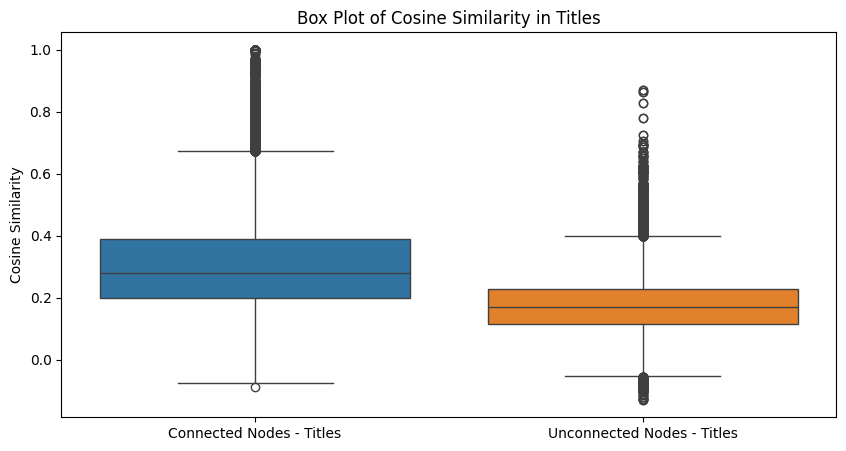

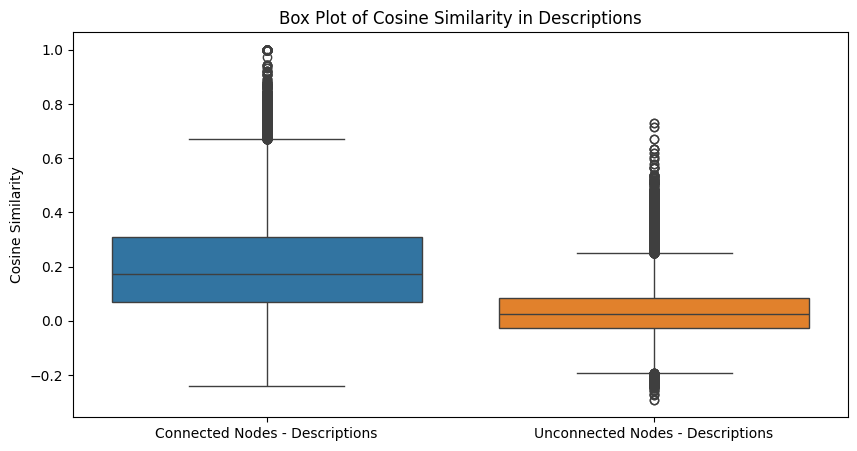

In [13]:
visualize_connected_vs_unconnected_cs_distribution(G, similarities)

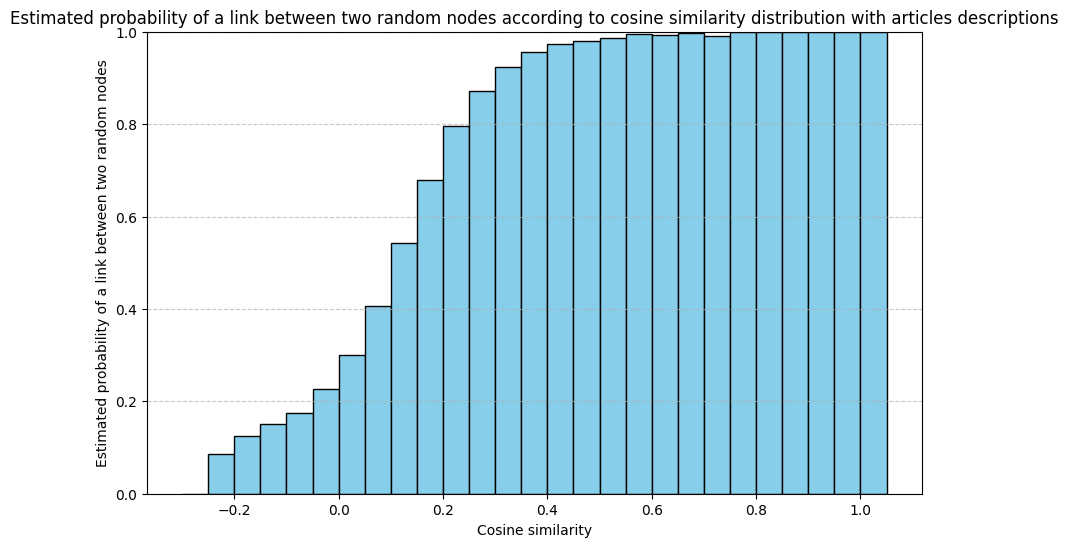

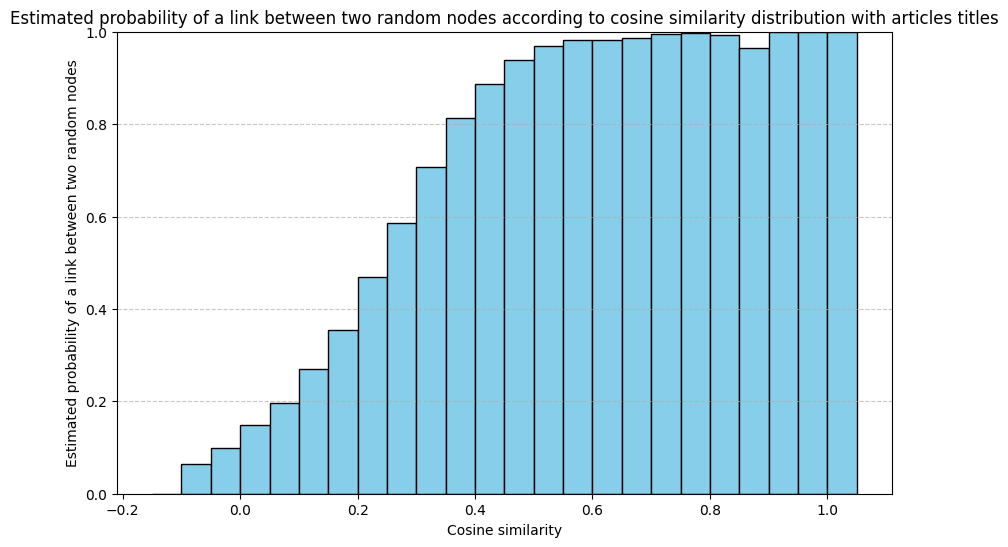

In [29]:
calculate_links_conditional_proba(G,similarities)

## 5. Feature engineering

To train the model, we introduce a set of handcrafted features tailored to the context of link prediction. These features are selected based on the project's aim and the statistical analyses conducted above. They are intended to be the most relevant for achieving effective link creation.

In this section, we start by exploring 4 methods based on node neighborhoods to quantify how likely two nodes are to form a link. These methods are discussed in the paper "The Link Prediction Problem for Social Networks", by Nowell et al.


We begin by computing and visualizing the preferential attachment scores for pairs of nodes, distinguishing between those that are connected and a subset of those that are unconnected. Preferential attachment is the principle that a node with more connections is more likely to acquire additional links. This approach assumes that the likelihood of a new connection involving a node x is directly proportional to the number of its existing neighbors. Additionally, the likelihood of two nodes, x and y, forming a co-authorship connection is related to the product of their respective collaborator counts.

Discussion: The preferential attachment scores for the connected pairs can have very large values because we have a very connected and sparse graph. However, some nodes havec a very high degree, resulting in large values (x_value range). In contrast, the preferential attachment scores for unconnected pairs are significantly smaller. This is due to the fact that these unconnected nodes, lacking a direct link, generally have less common neighbors, reducing the likelihood of a connection (under the preferential attachment mechanism). 
This difference highlights the impact of common neighbors on connection probability and underscores the structural differences between connected and unconnected pairs in the network.

/Users/alexislimozin/Documents/ada-2024-project-collectifmetisser/src/utils/Visualization.py:240: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0, 10000000)


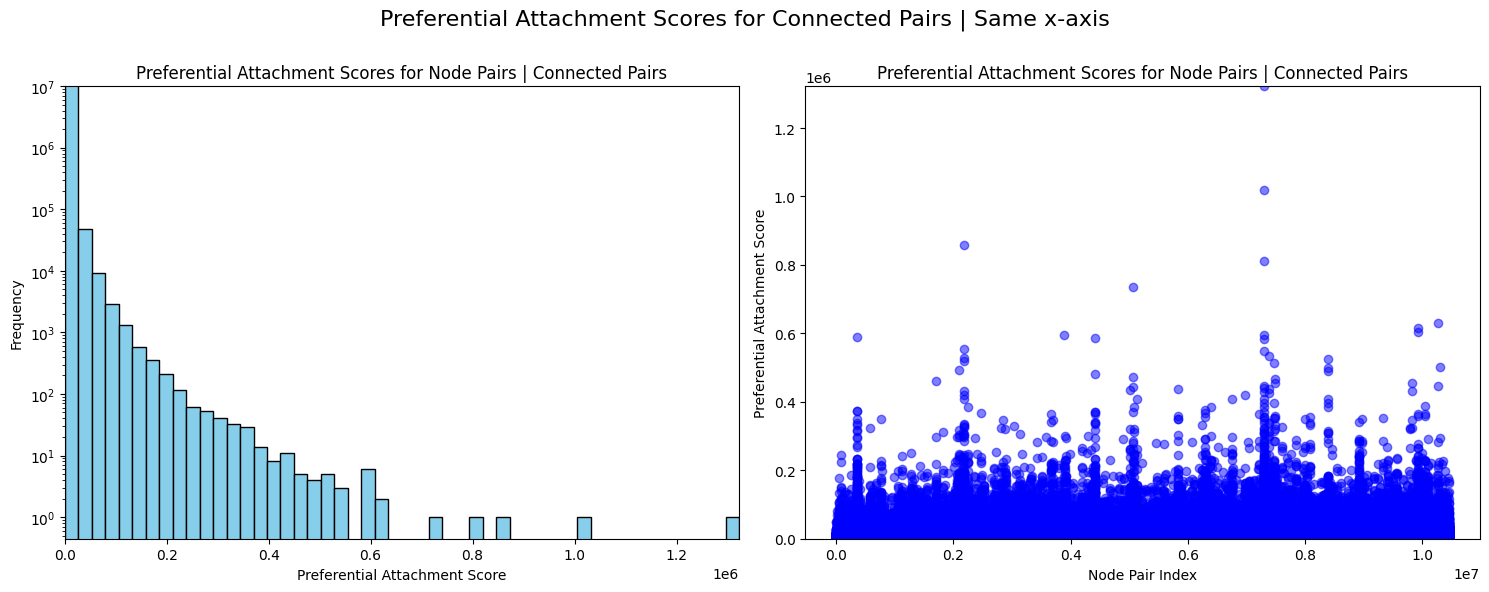

/Users/alexislimozin/Documents/ada-2024-project-collectifmetisser/src/utils/Visualization.py:259: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0, 10000000)


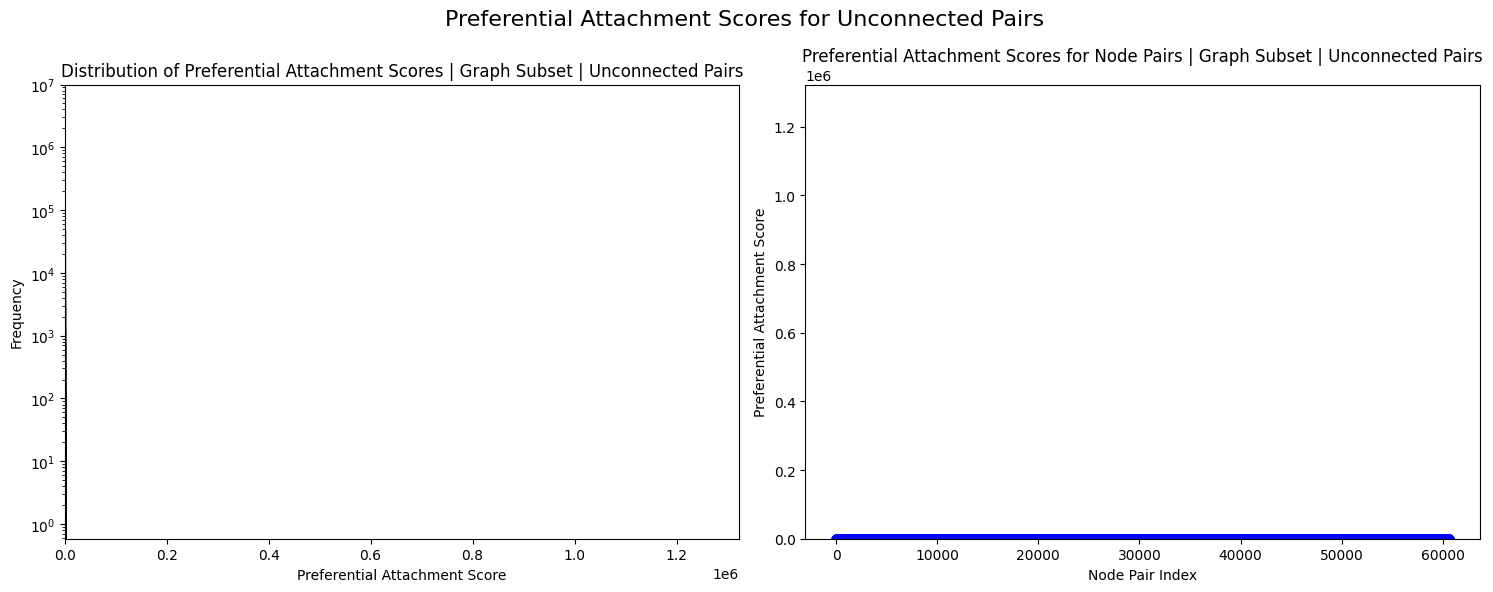

In [ ]:
calculate_preferential_attachment(G)

In the plots below and above, we illustrate the preferential attachment scores for connected and unconnected node pairs of our network. The unconnected nodes plots are replotted below to show the graph, since their values are minuscule compared to the connected pairs. 


/Users/alexislimozin/Documents/ada-2024-project-collectifmetisser/src/utils/Visualization.py:309: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0, 10000000)


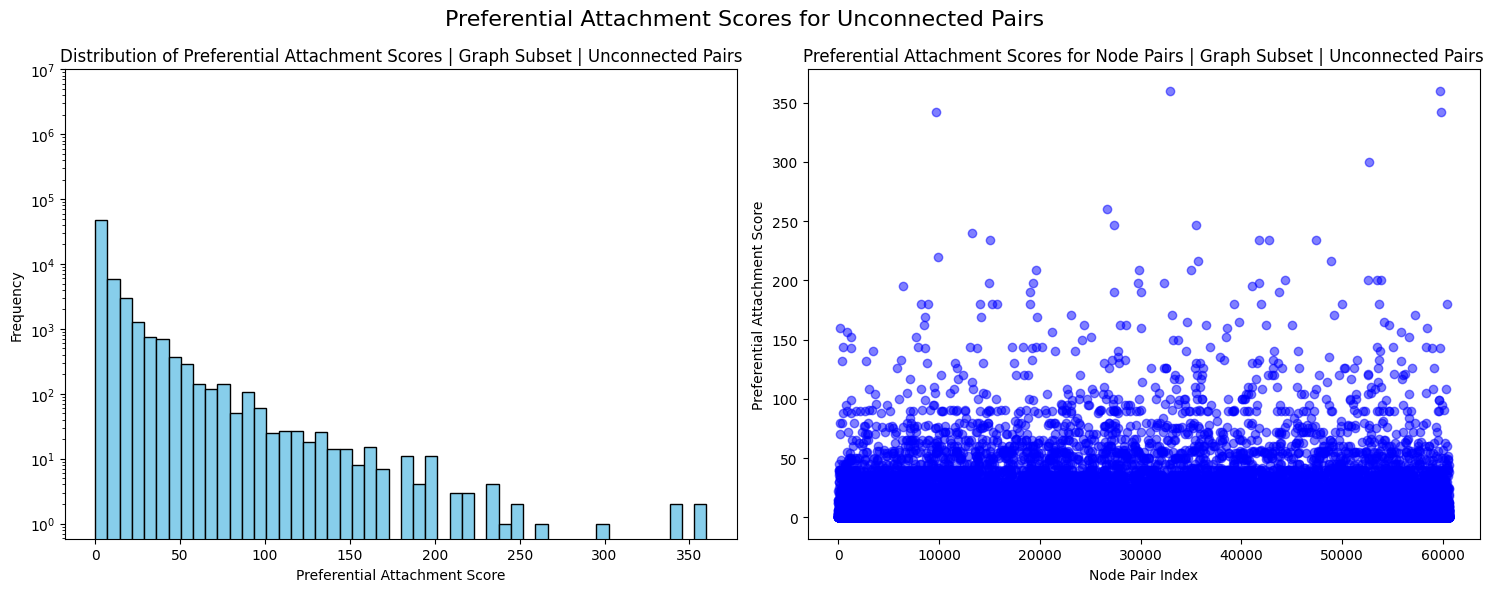

In [ ]:
calculate_preferential_attachment_unconnected_zoomed(G)

Now, we compare the number of common neighbors between two nodes x and y. Two nodes with a higher number of common neighbors have a higher probability to be linked in the future. 

Discussion: As expected, connected nodes have a higher number of common neighbors, whereas unconnected nodes have a smaller number of common neighbors. 

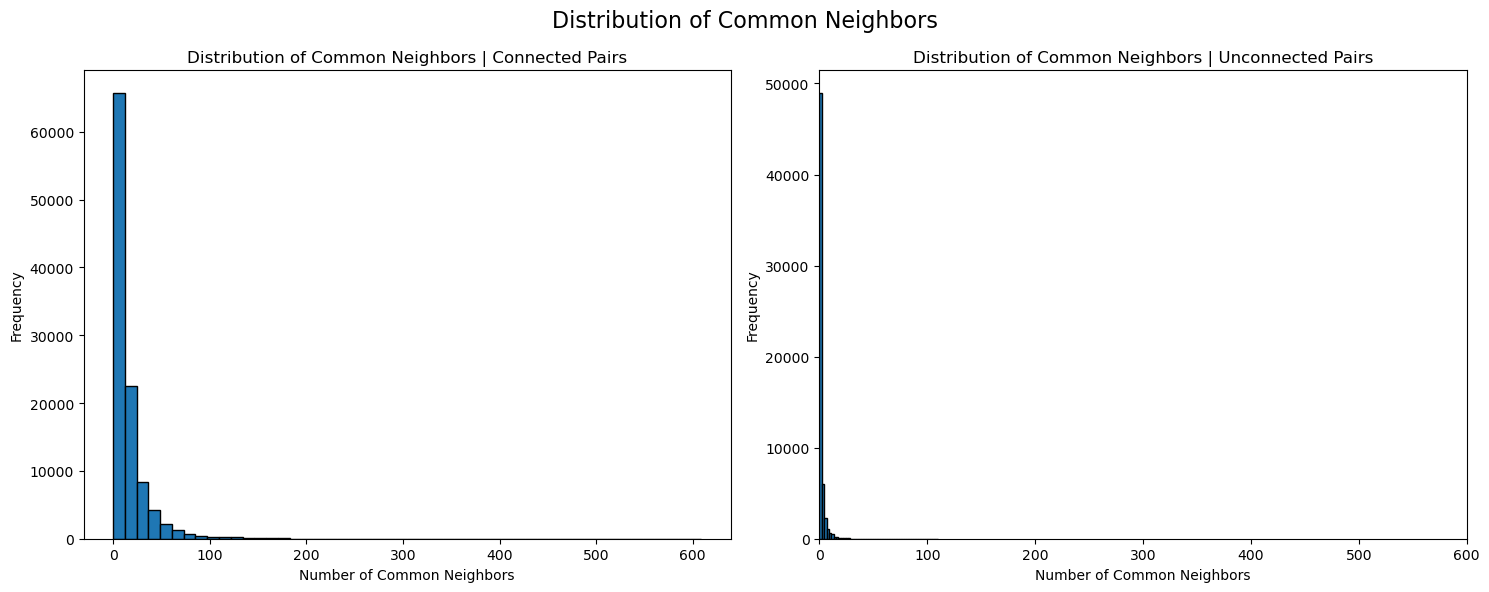

In [ ]:
calculate_common_neighbors(G)

In [20]:
#Nodes features 

#Calculate Eigen centrality for all node pairs
#There are others ways to compute the centrality btw
centrality = nx.eigenvector_centrality(subgraphs[0])
data = []
for u, v in centrality.items():
    data.append({"Article_1": u, "eigenvector": v})
    
#Get the values in a dataframe
df_eigen = pd.DataFrame(data)
df_eigen.sort_values("eigenvector", ascending=False, inplace=True)

#Links features

#Calculate Jaccard similarity for all node pairs
G_undirected=subgraphs[0].to_undirected()
jaccard_similarities = nx.jaccard_coefficient(G_undirected)
#Get the values in a dataframe
data = []
for u, v, p in jaccard_similarities:
    data.append({"Article_1": u, "Article_2": v, "jaccard_similarity": p})

df_jaccard = pd.DataFrame(data)
df_jaccard.sort_values("jaccard_similarity", ascending=False, inplace=True)

# Calculate Adamic_adar_index similarity for all node pairs
G_undirected=subgraphs[0].to_undirected()
adamic_adar_index = nx.adamic_adar_index(G_undirected)
#Get the values in a dataframe
data = []
for u, v, p in adamic_adar_index:
    data.append({"Article_1": u, "Article_2": v, "adamic_adar_index": p})

df_adamic = pd.DataFrame(data)
df_adamic.sort_values("adamic_adar_index", ascending=False, inplace=True)


In [21]:
df_eigen

,Article_1,eigenvector
3417,United_States,0.179635
4399,France,0.142220
720,United_Kingdom,0.137784
447,Europe,0.132176
3804,Germany,0.120921
...,...,...
2190,Ohm,0.000016
2038,Scheme_programming_language,0.000015
2323,Duchenne_muscular_dystrophy,0.000014
3754,Klinefelter's_syndrome,0.000014


In [22]:
df_jaccard

,Article_1,Article_2,jaccard_similarity
2748374,Australian_Green_Tree_Frog,White's_Tree_Frog,1.0
4514864,Emma_Roberts,T._D._Judah,1.0
3515136,Duchenne_muscular_dystrophy,Klinefelter's_syndrome,1.0
3133423,Reed_Bunting,Eurasian_Bullfinch,1.0
2938521,Hawfinch,Eurasian_Bullfinch,1.0
...,...,...,...
4609072,Comet_Hyakutake,TeX,0.0
4609070,Comet_Hyakutake,Mali,0.0
4609068,Comet_Hyakutake,Yuri_Knorosov,0.0
4609067,Comet_Hyakutake,British_Indian_Ocean_Territory,0.0


In [23]:
df_adamic

,Article_1,Article_2,adamic_adar_index
7280344,United_States,England,83.407958
2091993,Binomial_nomenclature,Chordate,72.607095
7279826,United_States,London,68.688406
2166355,Scientific_classification,Europe,59.432855
7359663,China,India,54.999616
...,...,...,...
4609072,Comet_Hyakutake,TeX,0.000000
4609070,Comet_Hyakutake,Mali,0.000000
4609068,Comet_Hyakutake,Yuri_Knorosov,0.000000
4609067,Comet_Hyakutake,British_Indian_Ocean_Territory,0.000000


We can also explore the difference of Jaccard's and Adamic/Adar Coefficients between connected and unconnected pairs.

The Jaccard's coefficient is a commonly used similarity metric in information retrieval. It measures the probability that both x and y have a feature f, knowing that x or y has the feature f (which is randomly selected). In our case, the features are the neighbors. 

Discussion: Below we compare the Jaccard's coefficients for both connected and unconnected node pairs. As expected, the Jaccard coefficient values are higher for connected node pairs, as the likelihood of sharing a neighbor increases when nodes are directly connected.

/Users/alexislimozin/Documents/ada-2024-project-collectifmetisser/src/utils/Visualization.py:413: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0,1e7)


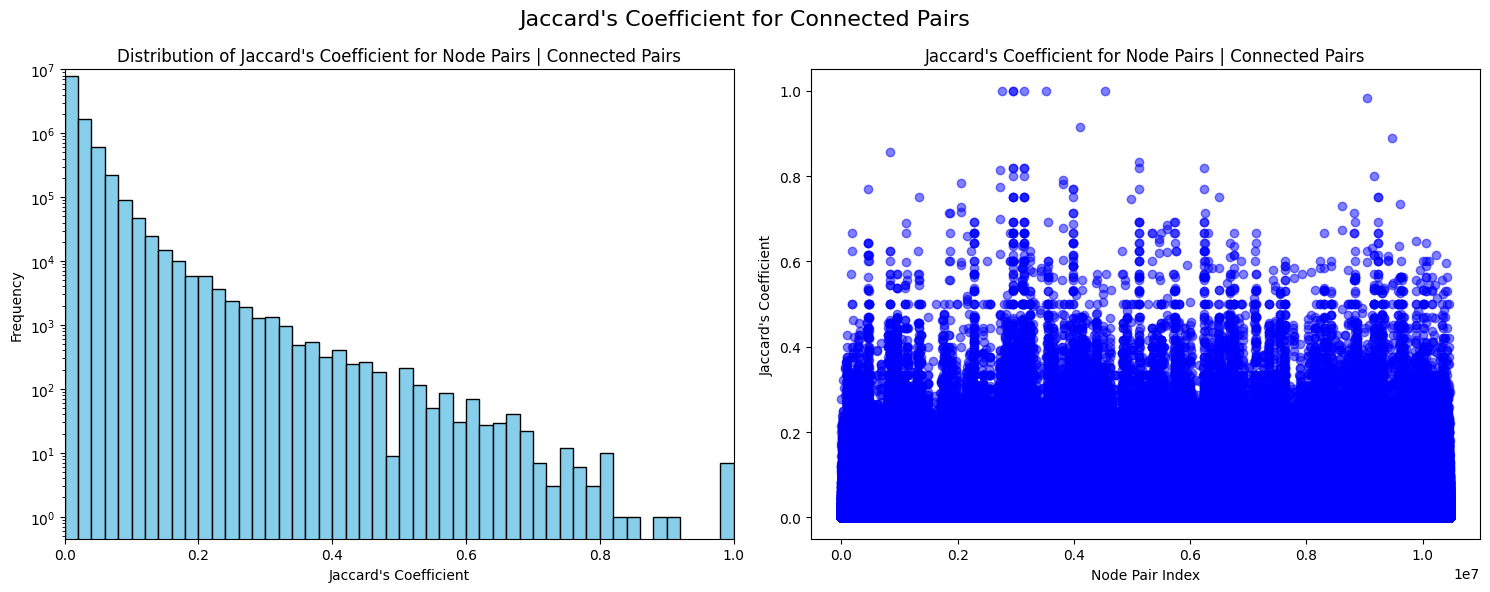

/Users/alexislimozin/Documents/ada-2024-project-collectifmetisser/src/utils/Visualization.py:429: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0,1e7)


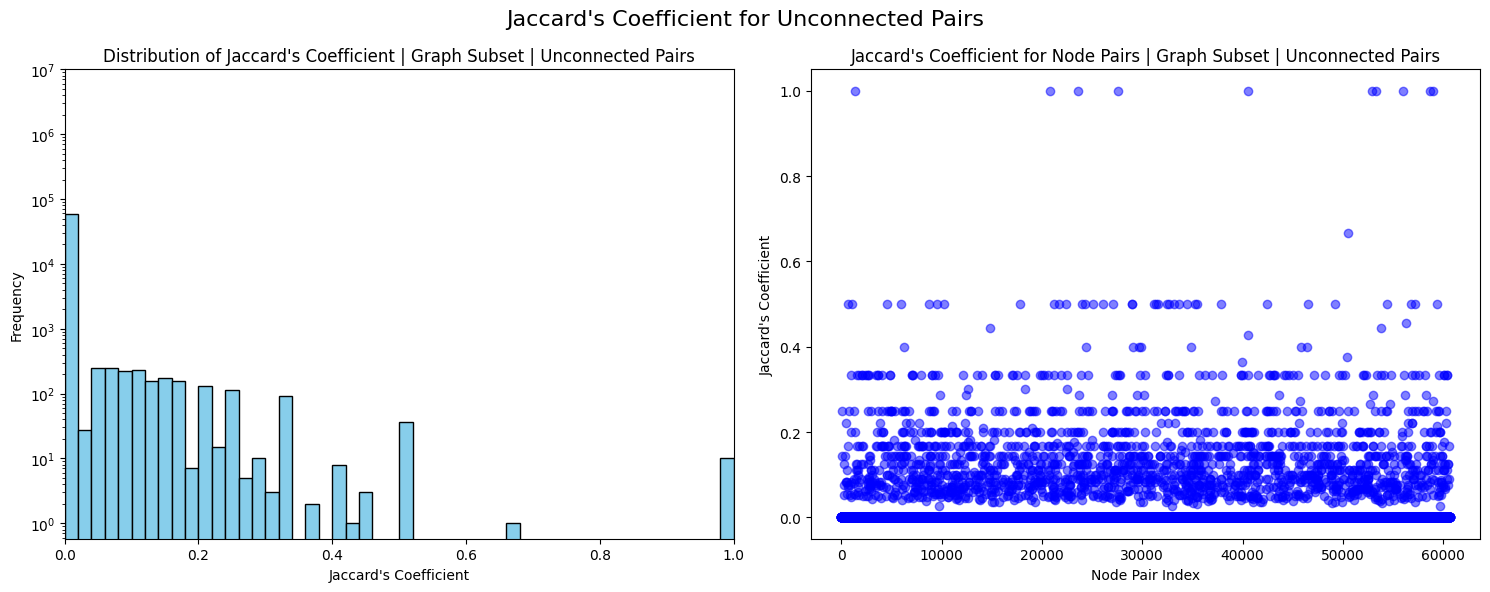

In [24]:
calculate_jaccards_coeff(G)

To determine how closely two personal home pages are linked, Adamic and Adar look into the common features. However, unlike a simple count of these common features, each distinctive or less frequent feature is given more weight in the score which acts as the measure for similarity between entities.

Discussion: We observed the differences between connected and unconnected pairs of nodes. As expected, the values for connected pairs of nodes are larger than those for unconnected pairs of nodes because there is a greater likelihood of shared connections or features when nodes are directly linked.

/Users/alexislimozin/Documents/ada-2024-project-collectifmetisser/src/utils/Visualization.py:474: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0,1e7)


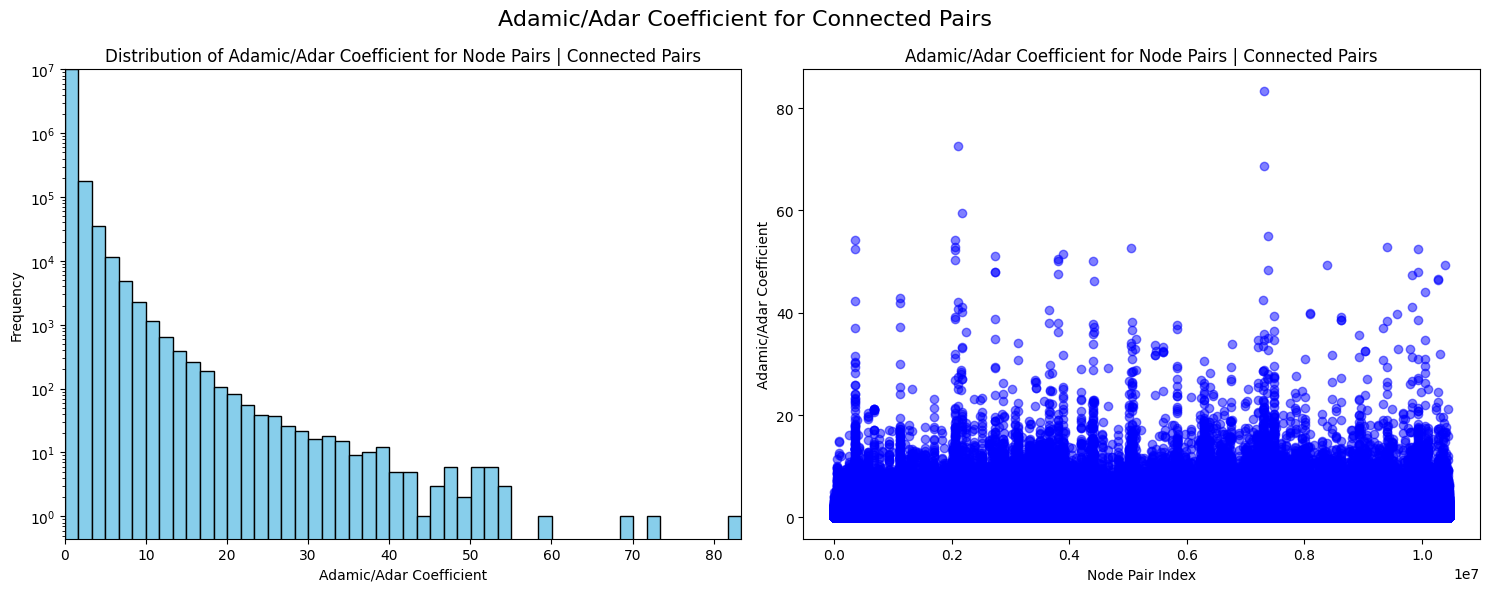

/Users/alexislimozin/Documents/ada-2024-project-collectifmetisser/src/utils/Visualization.py:490: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0,1e7)


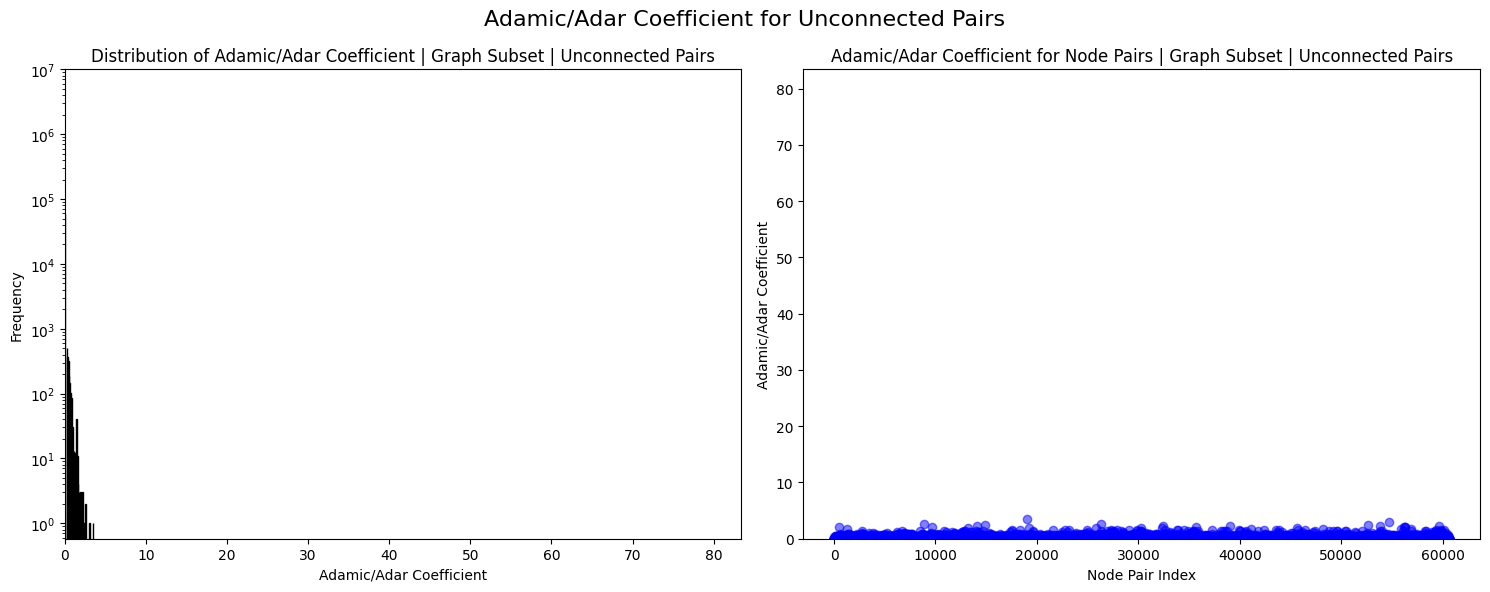

In [25]:
calculate_adamic_adar(G)

In [26]:
#PageRank algorithm, might be useful in our context, it shows how much a page is connected to the others

pr = nx.pagerank(subgraphs[0], alpha=0.9)
df_pagerank = pd.DataFrame(list(pr.items()), columns=['Article', 'PageRank_Score'])
df_pagerank

,Article,PageRank_Score
0,Second_Crusade,0.000135
1,Navassa_Island,0.000263
2,Evan_Rachel_Wood,0.000051
3,Tropical_Storm_Henri_(2003),0.000072
4,Final_Fantasy_Adventure,0.000045
...,...,...
4584,Réunion,0.000224
4585,Flower,0.000505
4586,Banknote,0.000141
4587,Weyto_language,0.000037
